In [69]:
# common imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# global variables
BANK_DATA_PATH = r"data/Bank Customer Churn Prediction.csv"
RANDOM_STATE = 42

# Getting the Data

In [70]:
def load_data(path=BANK_DATA_PATH):
    return pd.read_csv(path)

In [71]:
bank = load_data()
bank.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Quick look at the Data

In [72]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [73]:
# all customer id's are unique- so this column can be dropped
bank['customer_id'].nunique()

10000

In [74]:
bank['country'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

In [75]:
bank['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [76]:
# description of numerical attributes
bank.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


What we know so far:
* Credit score: minimum: 350, maximum: 850
* Age: minimum: 18, maximum: 92
* Balance: minimum: 0 (no negative values!), maximum: 250,898
* Number of products: minimum: 1, maximum: 4. These values make sense- if a customer has an account, they should be using at least one of the facilities/services the bank provides.
* Number of credit cards: minimum: 0, maximum: 1. This also seems reasonable- a customer can have an account but not have a credit card.
* Estimated salary: minimum: 11.58, maximum: 199,992.48.

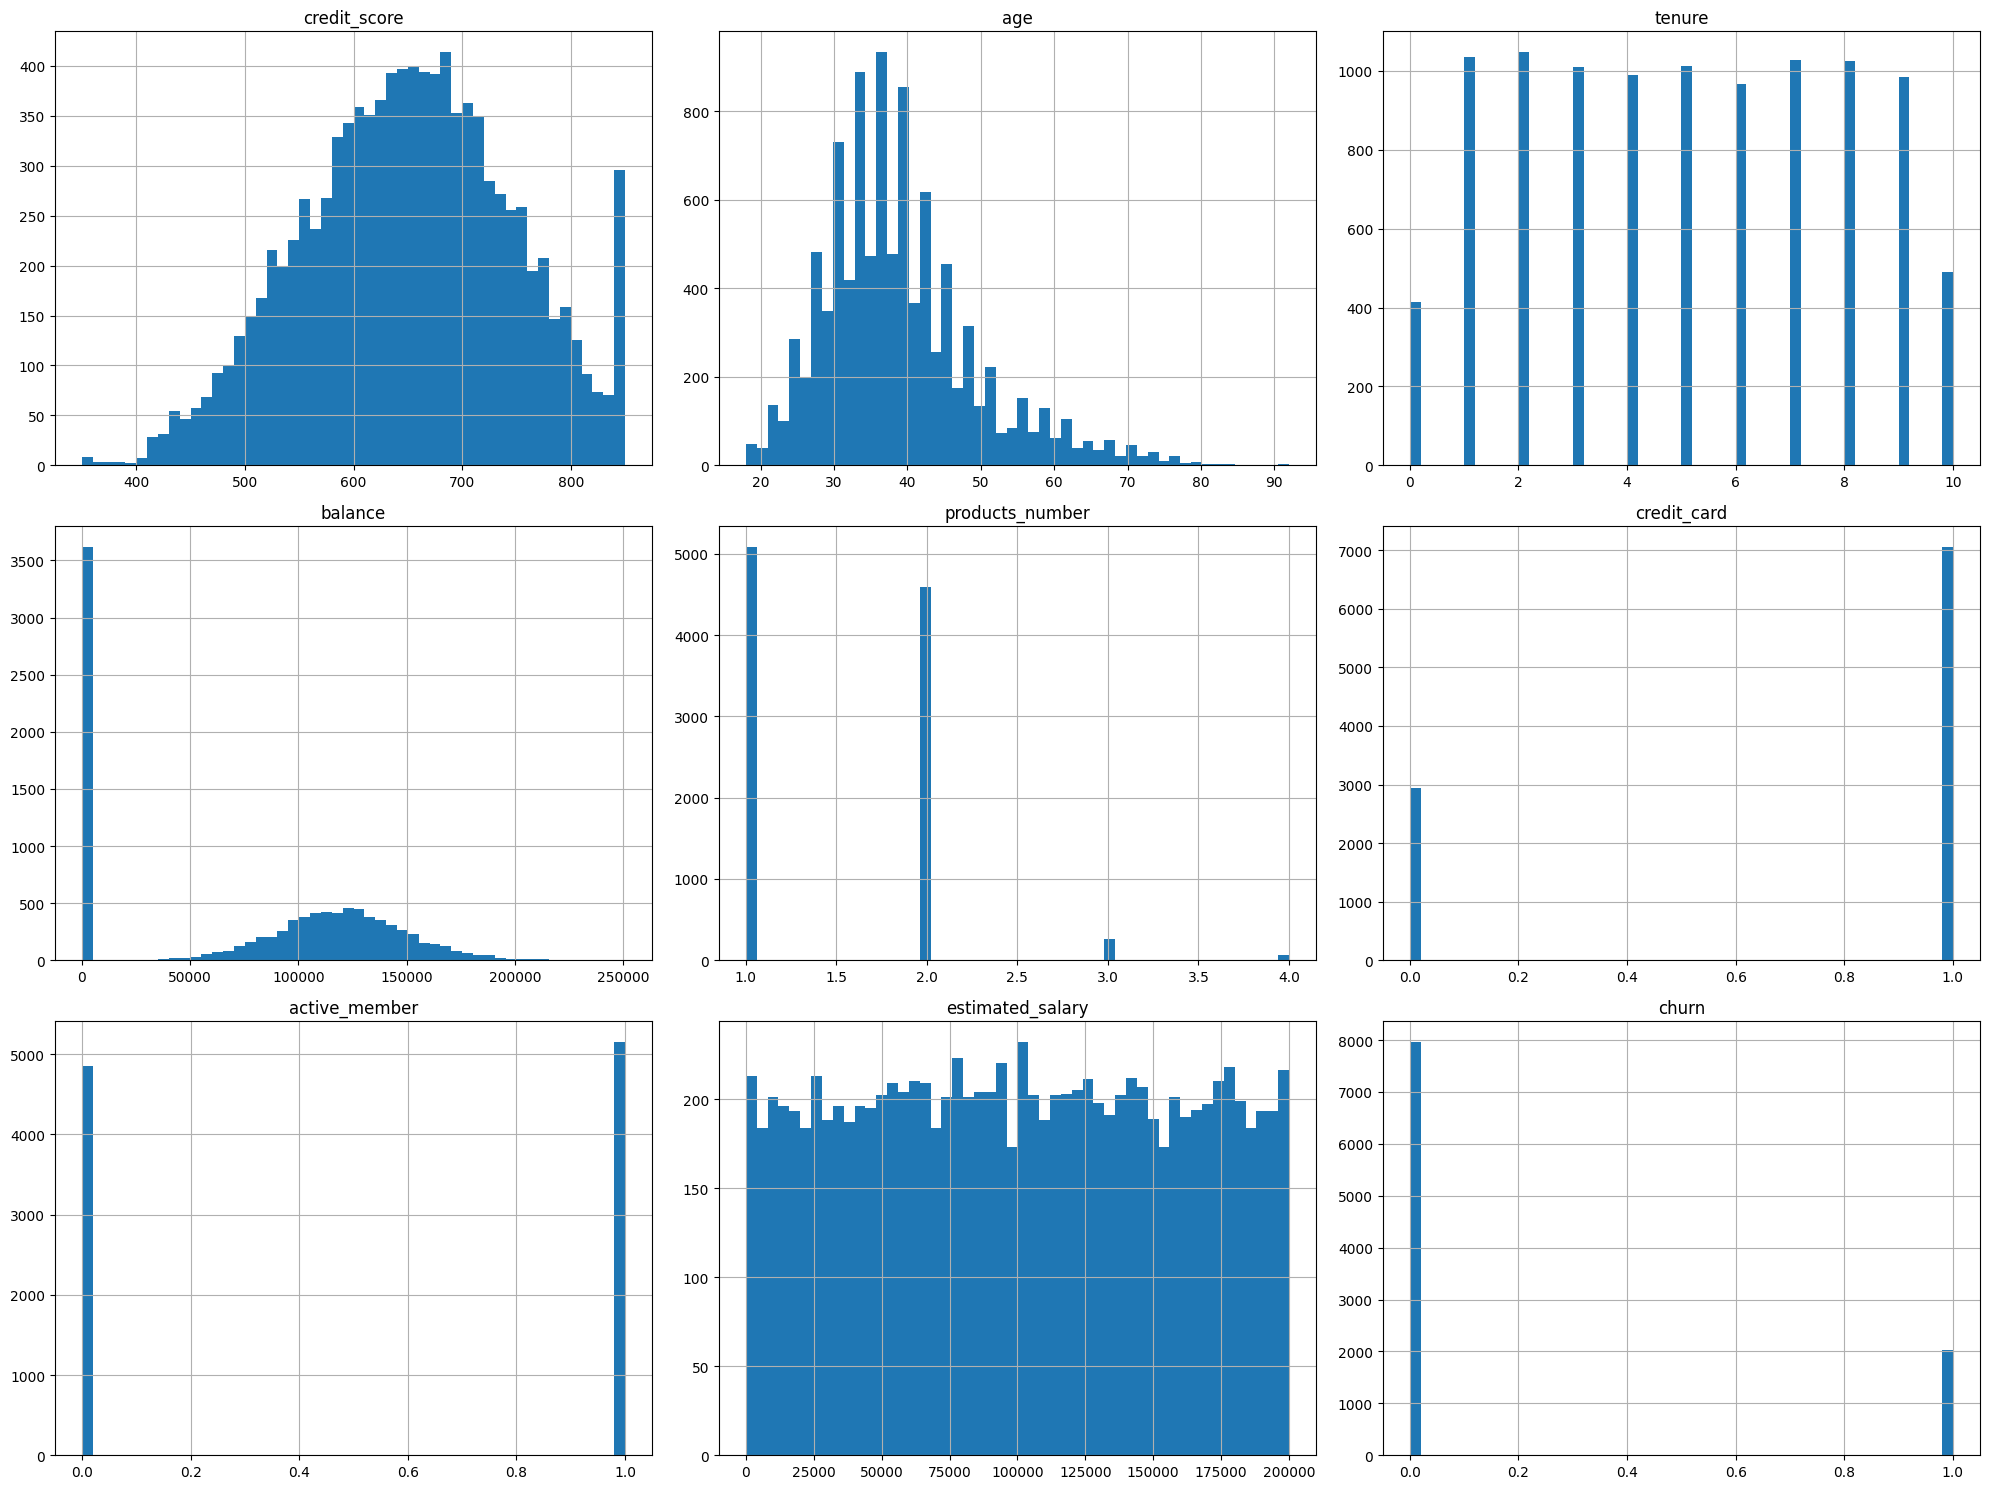

In [77]:
bank[bank.columns[1:]].hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

From the histograms:
* The credit_score, age, and balance columns resemble a bell curve.
* There are around 3500 accounts with 0 balance, which raises the question- are these inactive accounts?
* Most accounts are customers in their 30's-40's.
* Most people have had their account for 1 to 9 years. Few have had an account for less than a year, or 10 or more years.
* Customer's tend to have 1 or 2 products/services the bank provides and rarely have 3 or 4.
* The active_member and estimated salary columns spread nearly uniformly.

### CHALLENGE:
The histogram shows that the churn column is **imbalanced**. If we split the data randomly into a training and test set, there is a risk of sampling bias.
In other words, if we randomly split the data we could get a different distribution of the labels which would misrepresent the actual distribution.
This could affect the results of the trained models, especially since we only have 10,000 samples.
### SOLUTION:
We can use **stratified sampling** to divide the data. This way, the right amount of instances are sampled to guarantee the test set represents the overall population.

# Splitting the Data

In [78]:
def split_train_test_stratified(data, test_ratio=0.2, column_name='churn', random_state=RANDOM_STATE):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_state)
    for train_index, test_index in split.split(data, data[column_name]):
        train = data.loc[train_index]
        test = data.loc[test_index]
        return train, test


train_set, test_set = split_train_test_stratified(data=bank)

# Data Analysis and Visualization

# Data Cleaning
Our goal: Prepare the data for Machine Learning Algorithms.

In [79]:
X_train = train_set.drop('churn', axis=1)  # drop creates a copy of the data
y_train = train_set['churn'].copy()

X_test = test_set.drop('churn', axis=1)
y_test = test_set['churn'].copy()

### CHALLENGE:
Some columns are **categorical features** and contain string values.
Although some models can handle categorical features (such as Decision Trees), there are models like SVM which require features to be numerical.
These features need to be transformed to numerical values.
### SOLUTION
There are 2 techniques we could use:
#### 1. Encode with numbers, one per category.

Pros: Dimensionality will remain the same since no new feature columns are added.

Cons: Could cause some algorithms to learn that nearby values are more similar than distant ones (which is not always true).

#### 2. One-hot encoding: Create one binary attribute per category.

Pros: Solves the problem of the previous methods, in which unrelated columns could be affected by their assigned discrete values.

Cons: Increases dimensionality of the data, which increases the complexity and computational time required.
Could be costly especially when there are many categories.


TODO: feature scaling, choose method for categorical attribs

In [80]:
CATEGORICAL_FEATURES = ['country', 'gender']
NUMERICAL_FEATURES = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member',
                      'estimated_salary']

In [81]:
# by default, columns that are not listed will be dropped
# NOTE: The column customer_id is not listed, so it will be dropped.
pipeline = ColumnTransformer([
    ("num", StandardScaler(), NUMERICAL_FEATURES),
    ("cat", OneHotEncoder(), CATEGORICAL_FEATURES),
])

In [84]:
X_train_prepared = pipeline.fit_transform(X_train, y_train)

In [85]:
X_train_prepared

array([[ 1.058568  ,  1.71508648,  0.68472287, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.91362605, -0.65993547, -0.6962018 , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.07927399, -0.18493108, -1.73189531, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.16821031, -0.18493108,  1.3751852 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.37527024, -0.37493284,  1.02995403, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.56586482,  1.14508121,  0.68472287, ...,  1.        ,
         0.        ,  1.        ]])

In [86]:
X_train_prepared.shape

(8000, 13)

# Model Training